# Equivariant Filter Bias

Implementing the example in the "Overcoming Bias" paper by {cite:t}`https://doi.org/10.1109/LRA.2022.3210867` ([arxiv version](https://arxiv.org/pdf/2209.12038)).
This notebook was created by converting [Alessandro Fornasier's equivariant filter code](https://github.com/aau-cns/ABC-EqF) to use GTSAM's built-in data structures.

Authors: Jennifer Oum & Darshan Rajasekaran

<a href="https://colab.research.google.com/github/borglab/gtsam/blob/develop/python/gtsam/examples/EqF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GTSAM Copyright 2010-2022, Georgia Tech Research Corporation,
Atlanta, Georgia 30332-0415
All Rights Reserved

Authors: Frank Dellaert, et al. (see THANKS for the full author list)

See LICENSE for the license information

In [ ]:
# We start by installing gtsam (GTSAM's python wrapper) and gtbook.
%pip install --quiet gtsam gtbook

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import progressbar
import pandas as pd
import matplotlib.pyplot as plt
import math

import gtsam
from gtsam import findExampleDataFile, Rot3

from EqF import *

In [70]:
def formatCSV(df): # pass the dataframe in to this function and get "data_list" as an output
    """Read data from csv file formatted as follows:

    | -------------------------------------------------------------------------------------------- |
    | t: time                                                                                      |
    | -------------------------------------------------------------------------------------------- |
    | q_x, q_y, q_z, q_w: Quaternion representing the attitude                                     |
    | -------------------------------------------------------------------------------------------- |
    | b_x, b_y, b_z: Gyro bias                                                                     |
    | -------------------------------------------------------------------------------------------- |
    | cq_x_0, cq_yv, cq_z_0, cq_w_0: Quaternion representing the first calibration                 |
    | ...                                                                                          |
    | cq_x_n, cq_y_n, cq_z_n, cq_w_n: Quaternion representing the last calibration                 |
    | -------------------------------------------------------------------------------------------- |
    | w_x, w_y, w_z: Gyro measurements                                                             |
    | -------------------------------------------------------------------------------------------- |
    | std_w_x, std_w_x, std_w_z: Gyro measurements noise standard deviation                        |
    | -------------------------------------------------------------------------------------------- |
    | std_b_x, std_b_x, std_b_z: Gyro bias random walk standard deviation                          |
    | -------------------------------------------------------------------------------------------- |
    | y_x_0, y_y_0, y_z_0: Direction measurement in sensor frame associated to calibration state 0 |
    | ...                                                                                          |
    | y_x_n, y_y_n, y_z_n: Direction measurement in sensor frame associated to calibration state n |
    | y_x_n+1, y_y_n+1, y_z_n+1: Direction measurement in sensor frame from calibrated sensor      |
    | ...                                                                                          |
    | y_x_m, y_y_m, y_z_m: Direction measurement in sensor frame from calibrated sensor            |
    | -------------------------------------------------------------------------------------------- |
    | std_y_x_0, std_y_y_0, std_y_z_0: Standard deviation of direction measurement y_0             |
    | ...                                                                                          |
    | std_y_x_m, std_y_y_m, std_y_z_m: Standard deviation of direction measurement y_m             |
    | -------------------------------------------------------------------------------------------- |
    | d_x_0, d_y_0, d_z_0: Known direction in global frame associated to direction measurement 0   |
    | ...                                                                                          |
    | d_x_m, d_y_m, d_z_m: Known direction in global frame associated to direction measurement m   |
    | -------------------------------------------------------------------------------------------- |

    NaN cell means that value is not present at that time

    Max allowd n = 5
    Max allowd m = 10

    :param pname: path name
    """

    # read .csv file into pandas dataframe
    df = df.reset_index()

    # Define data_list as list
    data_list = []
    last_timestamp = df.t[0]

    # Check for existence of bias ground-truth into loaded data
    bias_exist = False
    if {'b_x', 'b_y', 'b_z'}.issubset(df.columns):
        bias_exist = True

    # Check for existence of calibration ground-truth (yaw, pitch, roll angles) into loaded data
    cal_exist = False
    n_cal = 0
    for i in range(6):
        if {'cq_x_' + str(i), 'cq_y_' + str(i), 'cq_z_' + str(i), 'cq_w_' + str(i)}.issubset(df.columns):
            cal_exist = True
            n_cal = i+1

    # Check for existence of direction measurements
    n_meas = 0
    for i in range(11):
        if {'y_x_' + str(i), 'y_y_' + str(i), 'y_z_' + str(i)}.issubset(df.columns):
            n_meas = i + 1

    for index, row in df.iterrows():

        # Load timestamps and record dt
        t = float(row['t'])
        dt = t - last_timestamp

        # Skip data_list if dt is smaller than a micro second
        if dt < 1e-6:
            continue

        last_timestamp = t

        # Load groundtruth values
        quat = np.array([float(row['q_x']), float(row['q_y']), float(row['q_z']), float(row['q_w'])])

        R = Rot3(gtsam.Rot3.Quaternion(float(row['q_w']), float(row['q_x']), float(row['q_y']), float(row['q_z'])).matrix())

        # Load Gyro biases
        if bias_exist:
            b = np.array([float(row['b_x']), float(row['b_y']), float(row['b_z'])]).reshape(3,)
        else:
            b = np.zeros(3)

        # Load GNSS calibration
        S = []
        if cal_exist:
            for i in range(n_cal):
                cal = np.array([float(row['cq_x_' + str(i)]), float(row['cq_y_' + str(i)]), float(row['cq_z_' + str(i)]), float(row['cq_w_' + str(i)])])
                S.append(Rot3(gtsam.Rot3.Quaternion(float(row['cq_w_' + str(i)]), float(row['cq_x_' + str(i)]), float(row['cq_y_' + str(i)]), float(row['cq_z_' + str(i)])).matrix()))


        # Load Gyro inputs
        w = np.array([float(row['w_x']), float(row['w_y']), float(row['w_z'])]).reshape(3,)
        std_w = np.array([float(row['std_w_x']), float(row['std_w_y']), float(row['std_w_z'])]).reshape(3,)
        std_b = np.array([float(row['std_b_x']), float(row['std_b_y']), float(row['std_b_z'])]).reshape(3,)
        Sigma_wb = blockDiag(np.eye(3) * (std_w ** 2), np.eye(3) * (std_b ** 2))

        # Load measurements
        meas = []
        for i in range(n_meas):
            y = np.array([float(row['y_x_' + str(i)]), float(row['y_y_' + str(i)]), float(row['y_z_' + str(i)])]).reshape(3,)
            d = np.array([float(row['d_x_' + str(i)]), float(row['d_y_' + str(i)]), float(row['d_z_' + str(i)])]).reshape(3,)
            std_y = np.array([float(row['std_y_x_' + str(i)]), float(row['std_y_y_' + str(i)]), float(row['std_y_z_' + str(i)])]).reshape(3,)
            if i < n_cal:
                meas.append(Measurement(y, d, np.eye(3) * (std_y ** 2), i))
            else:
                meas.append(Measurement(y, d, np.eye(3) * (std_y ** 2), -1))

        # Append to data_list
        d = Data(State(R, b, S), n_cal, Input(w, Sigma_wb), meas, n_meas, t, dt)
        
        data_list.append(d)

    return data_list

In [71]:
def sim(filter_args, data):

    # Define progressbar
    p = progressbar.ProgressBar()

    # EqF
    filter = EqF(*filter_args)

    # Allocate variables
    t = []
    est = []

    # Filter loop
    for d in p(data):

        t.append(d.t)

        # Run filter
        try:
            filter.propagation(d.u, d.dt)
        except:
            print('Filter.propagation Error\n')
        for y in d.y:
            if not (np.isnan(np.linalg.norm(y.y.d.unitVector())) or np.isnan(np.linalg.norm(y.d.d.unitVector()))):
                try:
                    filter.update(y)
                except:
                    print('Filter.update Error\n')
        est.append(filter.stateEstimate())

    # Plot Attitude1
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1)
    ax = [ax0, ax1, ax2]
    for i in range(3):
        ax[i].plot(t, [d.xi.R.rpy()[i] * 180 / math.pi for d in data], color="C0")
        ax[i].plot(t, [xi.R.rpy()[i] * 180 / math.pi for xi in est], color="C1")
        ax[i].set_xlabel("t")
    ax0.set_title("Attitude: Roll")
    ax1.set_title("Attitude: Pitch")
    ax2.set_title("Attitude: Yaw")
    plt.show()

    # Plot bias
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1)
    ax = [ax0, ax1, ax2]
    for i in range(3):
        ax[i].plot(t, [d.xi.b[i] for d in data], color="C0")
        ax[i].plot(t, [xi.b[i] for xi in est], color="C1")
        ax[i].set_xlabel("t")
    ax0.set_title("Bias: x")
    ax1.set_title("Bias: y")
    ax2.set_title("Bias: z")
    plt.show()


    # Plot calibration states
    for j in range(data[0].n_cal):
        fig, (ax0, ax1, ax2) = plt.subplots(3, 1)
        ax = [ax0, ax1, ax2]
        for i in range(3):
            ax[i].plot(t, [d.xi.S[j].rpy()[i] * 180 / math.pi for d in data], color="C0")
            ax[i].plot(t, [xi.S[j].rpy()[i] * 180 / math.pi for xi in est], color="C1")
            ax[i].set_xlabel("t")
        ax0.set_title("Calibration: Roll")
        ax1.set_title("Calibration: Pitch")
        ax2.set_title("Calibration: Yaw")
        plt.show()

# Run Equivariant Filter

(1) Load gyroscope and direction measurement data from EqFdata.csv. See formatCSV function for detailed description.

(2) Initialize the covariance, Sigma.

(3) Run the equivariant filter by passing in Sigma, number of calibration states, total number of available sensors, and the csv data to the sim function.

(4) Outputs 3 plots comparing the truth data (blue line) to the filter estimate (orange line.)

Loading dataset:



100% |########################################################################|


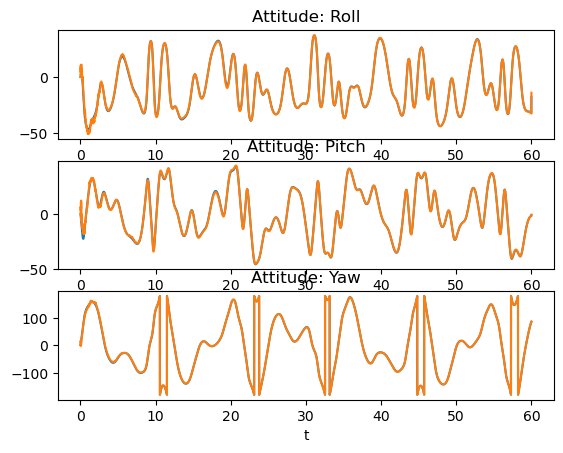

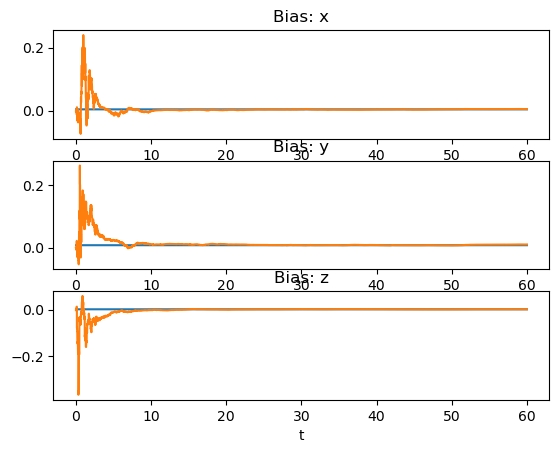

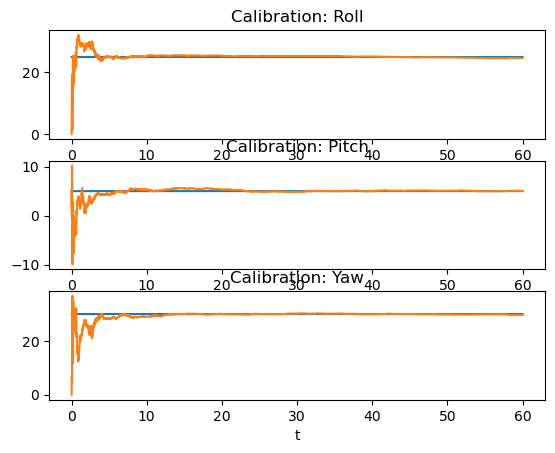

In [72]:
# Seed
np.random.seed(0)

# Load dataset
print(f"Loading dataset:\n")
df = pd.read_csv(findExampleDataFile("EqFdata.csv"))
data = formatCSV(df) 

# Define initial covariance
Score = blockDiag(np.eye(3), 0.1 * np.eye(3))
Scal = repBlock(np.eye(3), data[0].n_cal)
Sigma = blockDiag(Score, Scal)

# Run filter
filter_args = [Sigma, data[0].n_cal, data[0].n_meas]
sim(filter_args, data)
